# AIsteroid
[http://bit.ly/aisteroid](http://bit.ly/aisteroid)

In [2]:
from aisteroid import *
%matplotlib nbagg

## Task: Perform astrometry of images

### Choose the image set

In [3]:
if QIPY:
    #listImages() ##See the list of imagesets
    #CONF.SET="example" ##Choose your preferred imageset
    #CONF.CFG="example" ##You choose your preferred observatory configuration (example.cfg)
    CONF.OVERWRITE=1 ##Overwrite all previous actions
    CONF.VERBOSE=1 ## Show all outputs
    #CONF.SET='ps1-20180108_2_set199'

#### DO NOT TOUCH IF YOU ARE NOT SURE

In [4]:
#DO NOT MODIFY THIS LINES
print0("*"*60+"\nASTROMETRY OF IMAGE SET'%s'\n"%CONF.SET+"*"*60)

OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"
if not os.path.isdir(OUT_DIR):
    error("Set '%s' has not been unpacked"%CONF.SET)

CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]

PLOT_DIR=OUT_DIR+"plots/"
FLOG=open(OUT_DIR+"astrometria.log","a")
SYSOPTS=dict(qexit=[True,FLOG])

AIA_FILE=OUT_DIR+CONF.SET+".aia"
if not os.path.isfile(AIA_FILE):
    error("Detect task not ran yet on set '%s'"%CONF.SET)
else:
    AIA=pickle.load(open(AIA_FILE,"rb"))
    images=AIA["images"]
    sources=AIA["sources"]
    borders=AIA["borders"]
    nimgs=len(images)
    if nimgs==1:
        error("Analysis can't be ran with only just 1 image")

************************************************************
ASTROMETRY OF IMAGE SET'example'
************************************************************


### Telescope and camera (detector) properties

In [5]:
print0("Telescope & CCD Properties:")
if not "detector" in AIA.keys() or CONF.OVERWRITE:
    #Telescope and camera (detector) properties
    detector=dictObj(dict())
    detector.FOCAL=Config(CFG,"FocalLength") #mm
    detector.PW=Config(CFG,"PixelWide") #mm
    detector.PH=Config(CFG,"PixelHigh") #mm
    detector.SIZEX=images[0]["header"]["NAXIS1"]
    detector.SIZEY=images[0]["header"]["NAXIS2"]
    detector.PWD=np.arctan(detector.PW/detector.FOCAL)*RAD
    detector.PHD=np.arctan(detector.PW/detector.FOCAL)*RAD
    detector.PXSIZE=(detector.PWD+detector.PHD)/2
    
    
    AIA["detector"]=detector
    pickle.dump(AIA,open(AIA_FILE,"wb"))
else:
    print("\tDetector properties already extracted")
    AIA=pickle.load(open(AIA_FILE,"rb"))
    detector=AIA["detector"]

print0("\tFocal lenght (mm) :",detector.FOCAL)
print0("\tPixel size (x mm,y mm) :",detector.PW,detector.PH)
print0("\tImage size (x px,y px) :",detector.SIZEX,detector.SIZEY)
print0("\tPixel size (arcsec):",detector.PXSIZE/ARCSEC)
print0("\tCamera field (x deg,y deg) :",detector.SIZEX*detector.PWD,detector.SIZEY*detector.PHD)
print("\tDone.")

Telescope & CCD Properties:
	Focal lenght (mm) : 8070.0
	Pixel size (x mm,y mm) : 0.01 0.01
	Image size (x px,y px) : 2423 2434
	Pixel size (arcsec): 0.255594555449
	Camera field (x deg,y deg) : 0.172029335514 0.172810318878
	Done.


### Download stars in the field of the image set

In [6]:
print("Stars in the field covered by the images")

if not "stars" in AIA.keys() or CONF.OVERWRITE:
    
    rmin=sources["ALPHA_J2000"].min()
    rmax=sources["ALPHA_J2000"].max()
    dmin=sources["DELTA_J2000"].min()
    dmax=sources["DELTA_J2000"].max()
    rmean=(rmin+rmax)/2;dr=(rmax-rmin)/2
    dmean=(dmin+dmax)/2;dd=(dmax-dmin)/2
    ra=dec2sex(rmean/15)
    dec=dec2sex(dmean)
    ras="%d %d %.2f"%(int(ra[0]),int(ra[1]),ra[2])
    des="%d %d %.2f"%(int(dec[0]),int(dec[1]),dec[2])
    radius=np.sqrt(dr**2+dd**2)

    columns=['_RAJ2000','_DEJ2000','R1mag']
    v=Vizier(columns=columns)
    v.ROW_LIMIT=-1

    result=v.query_region("%s %s"%(ras,des),
                          width=Angle(2*dr,"deg"),height=Angle(2*dd,"deg"),
                          catalog='USNOB1')[0]
    cond=result["R1mag"]>0
    stars=pd.DataFrame(rec2arr(result[cond]),
                       columns=["ALPHA_J2000","DELTA_J2000","Rmag"])
    
    AIA["stars"]=stars
    pickle.dump(AIA,open(AIA_FILE,"wb"))
else:
    print("\tStars already detected")
    stars=AIA["stars"]
print("\tNumber of reference stars found:",len(stars))
print("\tDone.")
FLOG.write("Number of stars in the field: %d\n"%len(stars))
FLOG.flush()

Stars in the field covered by the images
	Number of reference stars found: 383
	Done.


### Show stars in the field

Showing stars in the field
	Done.


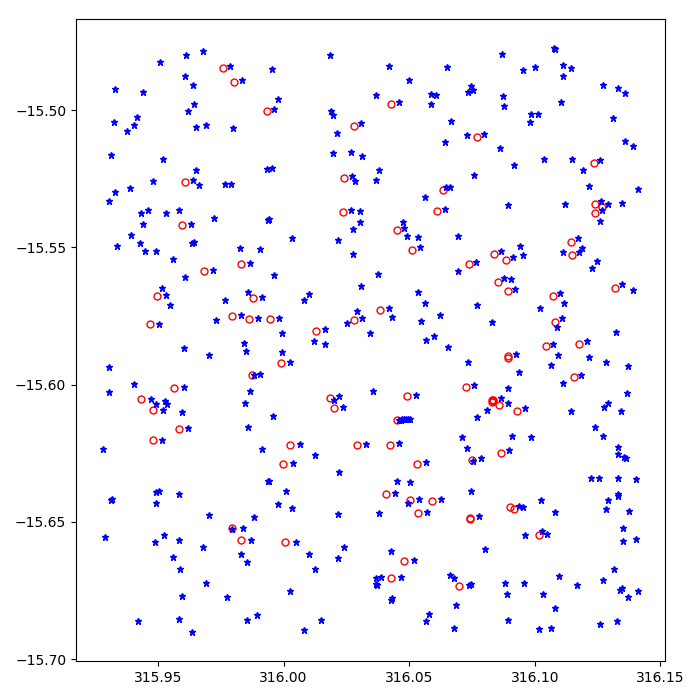

In [7]:
plotfile=PLOT_DIR+"stars-%s.png"%CONF.SET

if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    print0("Showing stars in the field")
    if not os.path.isfile(plotfile) or CONF.OVERWRITE:

        iimg=0
        imgsources=sources[sources.IMG==iimg][sources.MAG_BEST<-12]
        fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
        ax=axs

        #Show the sources
        ax.plot(imgsources["ALPHA_J2000"],imgsources["DELTA_J2000"],'ro',ms=5,mfc='None')
        ax.plot(stars["ALPHA_J2000"],stars["DELTA_J2000"],'b*',ms=5)

        fig.tight_layout()
        fig.savefig(plotfile)
    else:
        if CONF.QPLOT:print0("\tImage '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

### Matching detected stars with sources

In [8]:
print("Matching stars")

if len(sources[sources.STAR>0])==0 or CONF.OVERWRITE:
    
    if CONF.OVERWRITE:sources["STAR"]=0
    
    #Fields with coordinates
    a="ALPHA_J2000"
    d="DELTA_J2000"
    x="X_IMAGE"
    y="Y_IMAGE"
    cs=[x,y]

    for i,image in enumerate(images):
        file=image["file"]
        imgsources=sources[sources.IMG==i]
        border=borders[i]
        
        #Comparing set of sources
        print("\tMatching for image %s"%file)  

        #Choose the first NREFSTARS far from defects
        nbright=0
        indbright=[]
        for ind in imgsources.index:
            dmin=(np.sqrt((imgsources.loc[ind,x]-border[:,0])**2+\
                          (imgsources.loc[ind,y]-border[:,1])**2)).min()
            if dmin<2*CONF.RADIUS:continue
            indbright+=[ind]
            nbright+=1
            if nbright>=CONF.NREFSTARS:break
        
        bright=imgsources.loc[indbright]
        nbright=len(bright)

        print0("\t\tNumber of selected bright stars:",len(bright))

        adist=distanceSets([0,0],bright,stars,a,d)/nbright/ARCSEC
        print1("\t\tPresent average distance to stars:",adist)
        FLOG.write("Average error before astrometry in image %d: %f\n"%(i,adist))

        #Find optimal translation
        solution=minimize(distanceSets,[0,0],method='Nelder-Mead',tol=1e-6,args=(bright,stars,a,d))
        image["translation"]=solution.x

        print1("\t\tMatching parameters:",image["translation"])
        print1("\t\tImproved average distance:",distanceSets(image["translation"],bright,stars,a,d)/nbright/ARCSEC)

        #Translate position of stars
        bright[[a,d]]=[translation2D(image["translation"],[alpha,delta])\
                                     for alpha,delta in zip(bright[a],bright[d])]

        #Match bright sources and stars
        stars_ind=matchSets(bright,stars,a,d)
        zeros=stars.loc[stars_ind,"Rmag"].values-bright["MAG_BEST"].values
        image["zeropoint"]=zeros.mean()
        image["zerostd"]=zeros.std()
        FLOG.write("Zeropoint = %.2f\n"%image["zeropoint"])
        FLOG.write("Zeropoint error = %.2f\n"%image["zerostd"])

        #Aligning positions
        print1("\t\tAligning")    
        tr=SimilarityTransform()
        status=tr.estimate(bright[[a,d]].values,stars.loc[stars_ind,[a,d]].values)
        print1("\t\t\tSuccess:",status)
        image["astrometry"]=tr

        #Alligning all sources
        xy=imgsources[[a,d]].values
        xya=[]
        for j in range(xy.shape[0]):
            xyr=xy[j,:]
            xyr=translation2D(image["translation"],xyr)
            xyr=image["astrometry"](xyr).tolist()
            xya+=xyr
        xya=np.array(xya)

        imgsources[["RA","DEC"]]=pd.DataFrame(xya,columns=["RA","DEC"],index=imgsources.index)
        sources.loc[sources.IMG==i,["RA","DEC"]]=imgsources
        
        #Photometric properties
        sources.loc[indbright,"STAR"]=1
        sources.loc[sources.IMG==i,["MAG_ASTRO"]]=imgsources["MAG_BEST"]+image["zeropoint"]
        sources.loc[sources.IMG==i,["ERR_MAG_ASTRO"]]=(imgsources["MAGERR_BEST"]**2+image["zerostd"]**2).apply(np.sqrt)

        #Last verification
        nstars=stars.rename(columns={"ALPHA_J2000":"RA","DELTA_J2000":"DEC"})
        imgsources=sources[sources.IMG==i]
        bright=imgsources.loc[indbright]
        
        adist=distanceSets([0,0],bright,nstars,"RA","DEC")/nbright/ARCSEC
        print1("\t\tAverage distance to stars after astrometry:",adist)

        FLOG.write("Average error after astrometry in image %d: %f\n"%(i,adist))
        
    AIA["sources"]=sources
    AIA["images"]=images
    pickle.dump(AIA,open(AIA_FILE,"wb"))    
else:
    print("Stars already matched.")
    sources=AIA["sources"]
print("\tDone.")
FLOG.flush()

Matching stars
	Matching for image o8009g0075o.1299949.ch.1991737.XY51.p10
		Number of selected bright stars: 20
		Present average distance to stars: 11.8760787406
		Matching parameters: [ 0.00355096  0.15645567]
		Improved average distance: 1.70302121488
		Aligning
			Success: True
		Average distance to stars after astrometry: 1.15533501779
	Matching for image o8009g0096o.1299970.ch.1991758.XY51.p10
		Number of selected bright stars: 20
		Present average distance to stars: 11.8912451798
		Matching parameters: [ 0.00354497  0.16217656]
		Improved average distance: 1.78250805833
		Aligning
			Success: True
		Average distance to stars after astrometry: 1.142794575
	Matching for image o8009g0117o.1299991.ch.1991779.XY51.p10
		Number of selected bright stars: 20
		Present average distance to stars: 11.9463633044
		Matching parameters: [ 0.00358032  0.14751285]
		Improved average distance: 1.69072466499
		Aligning
			Success: True
		Average distance to stars after astrometry: 1.2101492353
	

### Show bright image alignment

In [ ]:
plotfile=PLOT_DIR+"starsalignment-%s.png"%CONF.SET

if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    print0("Showing stars in the field")
    if not os.path.isfile(plotfile) or CONF.OVERWRITE:

        fig,axs=plt.subplots(nimgs,2,figsize=(2*4,4*nimgs))
        imgargs=dict(cmap='gray_r',vmin=0,vmax=500)

        for i,image in enumerate(images):

            imgsources=sources[sources.IMG==i]
            bright=imgsources[imgsources.STAR==1]

            #Show the sources
            axs[i,0].imshow(image["data"],**imgargs)
            axs[i,0].plot(bright.loc[bright.index[:]]["X_IMAGE"],bright.loc[bright.index[:]]["Y_IMAGE"],'ro',ms=5,mfc='None')
            axs[i,0].set_title("Image %d"%i)
            axs[i,0].set_xticks([])
            axs[i,0].set_yticks([]) 
            
            axs[i,1].plot(stars.loc[stars.index[:]]["ALPHA_J2000"],stars.loc[stars.index[:]]["DELTA_J2000"],'b*',ms=5)
            axs[i,1].plot(bright.loc[bright.index[:]]["RA"],bright.loc[bright.index[:]]["DEC"],'ro',ms=5,mfc='None')

            axs[i,1].set_title("Image %d"%i)
            axs[i,1].set_xticks([])
            axs[i,1].set_yticks([]) 
            #break

        fig.tight_layout()
        fig.savefig(plotfile)
else:
    if CONF.QPLOT:print0("\tImage '%s' already generated."%plotfile)
print0("\tDone.")
Image(filename=plotfile)

In [ ]:
print0("Task completed.")
FLOG.close()